In [9]:
import numpy as np 
import pandas as pd
import matplotlib as mtl
import matplotlib.pyplot as plt
import seaborn as sns
from config import paths_to_raw_data
pd.set_option("display.max_rows", 300)

In [2]:
def extract(paths: dict) -> dict:

    """
    Extract data from a given paths.

    Parameters:
        - paths: dictionary with string path to files

    Return:
        - dict of pandas dataframes
    """

    item_cat = pd.read_csv(paths['item_cat'])
    items = pd.read_csv(paths['items'])
    sales_train = pd.read_csv(paths["sales_train"])
    shops = pd.read_csv(paths["shops"])
    test = pd.read_csv(paths["test"])

    return {'item_cat': item_cat, 'shops': shops, 'items': items, 'sales_train': sales_train, 'test': test}

In [3]:
%%time
data = extract(paths_to_raw_data)

CPU times: user 806 ms, sys: 184 ms, total: 990 ms
Wall time: 1.09 s


In [4]:
def inspect_table(data):
    report = []
    
    for t_name, df in data.items():
        nan_report = df.isna().sum(0) / len(df)
        unique_report = df.nunique()
        types = df.infer_objects().dtypes.astype(str)
        total = [len(df) for _ in range(len(df.columns))]

        report.append( pd.DataFrame(
            data=[
                nan_report.values,
                unique_report.values,
                types,
                total
            ],
            index=['nan_report', 'unique', 'dtype', 'total'],
            columns= pd.MultiIndex.from_tuples([(col, t_name) for col in df.columns], names=["column_name", "table_name"])
        ))
        
    return pd.concat(report, axis=1).transpose().reset_index().sort_values('column_name').set_index(["column_name", "table_name"])

# Basic statistics

In [22]:
report = inspect_table(data)
report

nan_report  unique    dtype    total
column_name        table_name                                      
ID                 test               0.0  214200    int64   214200
date               sales_train        0.0    1034   object  2935849
date_block_num     sales_train        0.0      34    int64  2935849
item_category_id   item_cat           0.0      84    int64       84
                   items              0.0      84    int64    22170
item_category_name item_cat           0.0      84   object       84
item_cnt_day       sales_train        0.0     198  float64  2935849
item_id            items              0.0   22170    int64    22170
                   sales_train        0.0   21807    int64  2935849
                   test               0.0    5100    int64   214200
item_name          items              0.0   22170   object    22170
item_price         sales_train        0.0   19993  float64  2935849
shop_id            shops              0.0      60    int64       60
                   sales_train        0.0      60    int64  2935849
                   test               0.0      42    int64   214200
shop_name          shops              0.0      60   object       60

• 0 nan values

In [5]:
from functools import partial
from itertools import combinations

def dqc_inspection__base(data, report):    
    report = report.reset_index()
    dqc_report = {}
    
    # Step: schema key consistency
    col_cnt = report.groupby('column_name').table_name.count().reset_index()
    merging_cols = list(col_cnt[col_cnt.table_name > 1].column_name)
    merging_cols__tables = report[report.column_name.isin(merging_cols)]
    
    consistency_table__data = {}
    
    for col in merging_cols:
        table_names = merging_cols__tables[merging_cols__tables.column_name == col]
        
        id_table_pairs = list(combinations(table_names.table_name.values, 2))
        
        for l_table, r_table in id_table_pairs:
        
            cmp_key = f"[{col}] {l_table} - {r_table}"
            l_unique = set(data[l_table][col].unique())
            r_unique = set(data[r_table][col].unique())

            inter_len = len(l_unique.intersection(r_unique))
            consistency_table__data__row = (len(l_unique) - inter_len, inter_len, len(r_unique) - inter_len)

            consistency_table__data[cmp_key] = consistency_table__data__row
        
    dqc_report["consistency_table"] = pd.DataFrame(data=consistency_table__data.values(), columns=['left_cnt_only', 'intersect_len', 'right_cnt_only'], index=consistency_table__data.keys())
     
    
    numeric_report = {}
    aggregation_mapping = {
        'min': min,
        **{
            f'perc_{thresh}': partial(np.quantile, q=(0.01 * thresh), method='nearest') for thresh in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 96, 97, 98, 99]
        },
        'max': max,
    }
    
    # Step: floating point range check
    report__float_rows = report[report.dtype.isin(["float", "float16", "float32", "float64"])]
    
    for _, row in report__float_rows.iterrows():
        col = row.column_name
        tbl = row.table_name
        
        freport_key = f"[Float range] {tbl} - {col}"
        vals = data[tbl][col].values
        freport__tuple = [f(vals) for f in aggregation_mapping.values()]
        
        numeric_report[freport_key] = freport__tuple


    # Step: id duplication stat
    duplication_report = {}
    duplication_candidates = report[report.apply(lambda row: 'id' in row.column_name, axis=1)]
    
    for _, row in duplication_candidates.iterrows():
        col = row.column_name
        tbl = row.table_name
        
        duplication_key = f"[Occurence stat] {tbl} - {col}"
        vals = data[tbl][col].value_counts().values
        duplication_row = [f(vals) for f in aggregation_mapping.values()]
        
        numeric_report[duplication_key] = duplication_row
        
    dqc_report["numeric_report"] = pd.DataFrame(data=numeric_report.values(), columns=aggregation_mapping.keys(), index=numeric_report.keys())
    
    return dqc_report

In [31]:
dqc_base_report = dqc_inspection__base(data, report)
dqc_base_report['consistency_table']

,left_cnt_only,intersect_len,right_cnt_only
[item_category_id] item_cat - items,0,84,0
[item_id] items - sales_train,363,21807,0
[item_id] items - test,17070,5100,0
[item_id] sales_train - test,17070,4737,363
[shop_id] shops - sales_train,0,60,0
[shop_id] shops - test,18,42,0
[shop_id] sales_train - test,18,42,0


#### Overview
•  There are examples in the test set, that aren't presented in sales_train. That means we cannot make any reasonable predictions for them.

•  Not all shops are presented in the test set.

In [32]:
dqc_base_report['numeric_report']

,min,perc_1,perc_2,perc_3,perc_4,perc_5,perc_10,perc_20,perc_30,perc_40,...,perc_60,perc_70,perc_80,perc_90,perc_95,perc_96,perc_97,perc_98,perc_99,max
[Float range] sales_train - item_cnt_day,-22.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,2.0,2.0,3.0,3.0,5.0,2169.0
[Float range] sales_train - item_price,-1.0,5.0,58.0,79.0,99.0,99.0,149.0,199.0,299.0,349.0,...,599.0,799.0,1199.0,1999.0,2690.0,2999.0,3190.0,3590.0,5999.0,307980.0
[Occurence stat] item_cat - item_category_id,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
[Occurence stat] items - item_category_id,1.0,1.0,1.0,1.0,2.0,2.0,4.0,7.0,12.0,20.0,...,151.0,228.0,317.0,598.0,790.0,1125.0,1780.0,1780.0,2365.0,5035.0
[Occurence stat] items - item_id,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
[Occurence stat] sales_train - item_id,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,10.0,18.0,...,55.0,90.0,160.0,331.0,556.0,655.0,775.0,993.0,1513.0,31340.0
[Occurence stat] test - item_id,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,...,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0
[Occurence stat] shops - shop_id,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
[Occurence stat] sales_train - shop_id,306.0,499.0,499.0,1792.0,1792.0,3412.0,5027.0,13440.0,25532.0,38179.0,...,49225.0,53910.0,63911.0,105366.0,142234.0,143480.0,143480.0,186104.0,186104.0,235636.0
[Occurence stat] test - shop_id,5100.0,5100.0,5100.0,5100.0,5100.0,5100.0,5100.0,5100.0,5100.0,5100.0,...,5100.0,5100.0,5100.0,5100.0,5100.0,5100.0,5100.0,5100.0,5100.0,5100.0


#### Overview
•  There are range outliers in [**sales_train - item_price**] and [**sales_train - item_cnt_day**].

•  There are ouccurence outliers in [**sales_train - items_id**].

•  Every item and shop are presented in the set equal amount of times.


### Overall
• Amount of items sold per purchase among all shops is in range [1-5] (Need to verify negative values and outliers from business perspective).

• Item price has a wide range of values but also is affected with neg values and outliers.

• A huge mass of items is poorly represented in train (need to be tackled somehow as well) + outliers.

----------------------------------------------------------------------------------------------------------------

#### Negative values check
Here we have 2 columns:

• sales_train - item_price

• sales_train - item_cnt_day

In [14]:
raw_train = data['sales_train']

neg_item_price = raw_train[raw_train.item_price <= 0.0]
print(f"Percentage of neg samples: {100 * (len(neg_item_price) / len(raw_train))}")

neg_item_price

Percentage of neg samples: 3.406169731481422e-05


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


Can be easily dropped

In [15]:
neg_item_cnt_day = raw_train[raw_train.item_cnt_day <= 0.0]
print(f"Percentage of neg samples: {100 * (len(neg_item_cnt_day) / len(raw_train))}")

neg_item_cnt_day

Percentage of neg samples: 0.2505578454477734


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
148,23.01.2013,0,25,2321,999.0,-1.0
175,07.01.2013,0,25,2199,1449.0,-1.0
807,02.01.2013,0,25,2330,599.0,-1.0
1041,13.01.2013,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934243,26.10.2015,33,25,3917,449.0,-1.0
2934462,18.10.2015,33,25,4896,6398.0,-1.0
2935263,05.10.2015,33,25,10039,249.0,-1.0
2935643,16.10.2015,33,25,7893,2990.0,-1.0


### Was it a return or a mistake?
**Core assupmtions for a return:**

• They can occure in every shop

• They can occure at any time

• They might have some patterns in terms of items and their price

Amount of shops with at least 1 potential return: 54


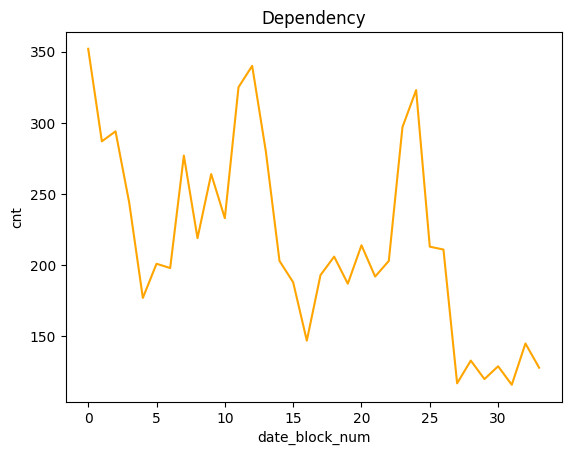

In [16]:
series = neg_item_cnt_day.groupby('date_block_num').date.\
                            agg('count').reset_index().rename({'date': 'cnt'}, axis=1)

sns.lineplot(data=series, x='date_block_num', y='cnt', color=mtl.colors.to_rgb('orange')).set_title('Dependency')
print(f"Amount of shops with at least 1 potential return: {len(neg_item_cnt_day.groupby('shop_id').date.agg('count').reset_index().rename({'date': 'cnt'}, axis=1))}")

They are returns

----------------------------------------------------------------------------------------------------------------

Now looking at right boundary of **item_cnt_day** and **item_price**

In [6]:
def markov_probability_tresh(data, prob=0.03):
    """
        Parameters:
         - data -> list of numerical values X_i >= 0
         - prob -> probability, that occurence will exceed the threshold
         
        Returns:
         - thresh -> threshold, that satisfy P(x >= thresh; data) <= prob
    """
    assert len(list(filter(lambda el: el < 0.0, data))) == 0, "Series should satisfy non-negative value range"
    
    data_mean = np.mean(data)
    return data_mean / prob 

[sales_train | item_cnt_day] Markov thresh on 1.0%: 124.8337284739967
[sales_train | item_cnt_day] Markov thresh on 0.5%: 249.6674569479934
[sales_train | item_cnt_day] Markov thresh on 0.1%: 1248.337284739967
[sales_train | item_price] Markov thresh on 1.0%: 89085.35364784647
[sales_train | item_price] Markov thresh on 0.5%: 178170.70729569293
[sales_train | item_price] Markov thresh on 0.1%: 890853.5364784646


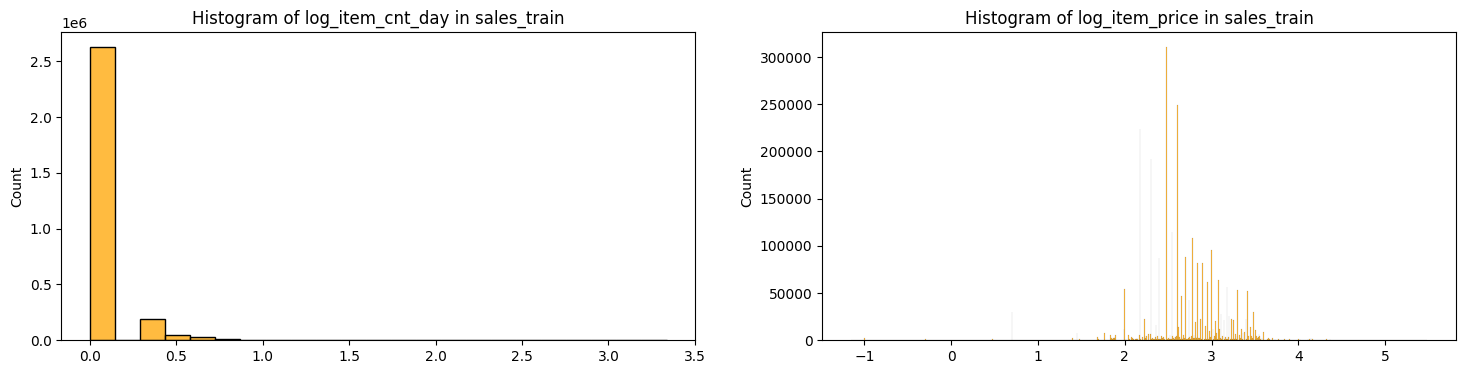

In [11]:
candidates = [
    ('sales_train', 'item_cnt_day'),
    ('sales_train', 'item_price')
] 

fig, axs = plt.subplots(1,len(candidates), figsize=(18, 4))

for idx, (tbl, col) in enumerate(candidates):
    vals = list(filter(lambda x: x > 0, data[tbl][col].to_numpy().flatten()))
    
    is_log = max(vals) - min(vals) > 1e3
    
    sns.histplot(data=np.log10(vals) if is_log else vals, ax=axs[idx], color=mtl.colors.to_rgb('orange')).set_title(f'Histogram of {"log" if is_log else None}_{col} in {tbl}')
    for perc in [0.01, 0.005, 0.001]:
        print(f"[{tbl} | {col}] Markov thresh on {100 * perc}%: {markov_probability_tresh(vals, prob=perc)}")

## Looking closer at each table:

# Item categories #

In [22]:
data['item_cat'].sample(10)
# description is clean

,item_category_name,item_category_id
55,Музыка - CD локального производства,55
41,Кино - Коллекционное,41
3,Аксессуары - PS4,3
33,Карты оплаты - Live!,33
23,Игры - XBOX 360,23
70,Подарки - Сувениры (в навеску),70
37,Кино - Blu-Ray,37
82,Чистые носители (штучные),82
16,Игровые консоли - XBOX ONE,16
22,Игры - PSVita,22


In [23]:
data['item_cat'].describe(include=[object])
# no duplicates

,item_category_name
count,84
unique,84
top,PC - Гарнитуры/Наушники
freq,1


# Shops 

In [26]:
shops = data['shops']

In [27]:
shops.iloc[:]
# shops 38-40 have very similar names, but their sales and counts of 
# items is kinda different, so i decided to leave them.

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [28]:
shops['shop_name'] = shops['shop_name'].str.replace("!|\?|²|\*|/| фран", '', regex=True)
shops.head(10)
# cleaning shop names from excess symbols

,shop_name,shop_id
0,"Якутск Орджоникидзе, 56",0
1,"Якутск ТЦ ""Центральный""",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [29]:
shops.describe(include=[object])
# after cleaning have appeared duplicates

,shop_name
count,60
unique,57
top,"Якутск Орджоникидзе, 56"
freq,2


In [30]:
shops.loc[shops.duplicated("shop_name", keep=False)]

,shop_name,shop_id
0,"Якутск Орджоникидзе, 56",0
1,"Якутск ТЦ ""Центральный""",1
10,Жуковский ул. Чкалова 39м,10
11,Жуковский ул. Чкалова 39м,11
57,"Якутск Орджоникидзе, 56",57
58,"Якутск ТЦ ""Центральный""",58


In [92]:
# dealing with duplicates with same name but different id:
# 1. If in test set are presented more than 1 duplicates of the shop, 
#    deciding to not touch them.
# 2. If only 1 or 0(i.e. shop isn't in test set) duplicats of shop are 
#    presented in test set, then merging their id.
dup = shops.loc[shops.duplicated("shop_name", keep=False)] \
    .groupby("shop_name") \
    .agg(lambda x: list(x)) \
    .shop_id
test_shops = test.shop_id.to_numpy()
for idx, value in dup.items():
    value: np.ndarray = np.array(value)
    mask = np.isin(value, test_shops)
    if np.sum(mask) < 2:
        shops.loc[value, 'shop_id'] = value[mask][0] if value[mask].size > 0 else value[0]
        shops.drop_duplicates("shop_id", inplace=True)
        sales_train.loc[sales_train.shop_id.isin(value), 'shop_id'] = value[mask][0] if value[mask].size > 0 \
            else value[0]
shops.reset_index(drop=True, inplace=True)

In [93]:
shops.loc[shops.duplicated("shop_name")]
# no duplicates after cleaning

,shop_name,shop_id


In [94]:
shops.loc[:]

,shop_name,shop_id
0,"Якутск Орджоникидзе, 56",57
1,"Якутск ТЦ ""Центральный""",58
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [95]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  57 non-null     object
 1   shop_id    57 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ KB


# Items #

In [31]:
items = data['items']

In [32]:
 items.head(20)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


In [98]:
items['item_name'] = items['item_name'].str.replace("!|\?|²|\*|/", '', regex=True)
items.head(20)
# cleaning item names from excess symbols

,item_name,item_id,item_category_id
0,ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,ABBYY FineReader 12 Professional Edition Full ...,1,76
2,В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,КОРОБКА (СТЕКЛО) D,4,40
5,НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) D,5,40
6,УДАР ПО ВОРОТАМ (UNI) D,6,40
7,УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,ЧАЙ С МУССОЛИНИ D,8,40
9,ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


In [100]:
items.describe(include=[object])

,item_name
count,22170
unique,22166
top,МУЖИКИ (регион)
freq,2


In [101]:
items.loc[items.duplicated('item_name', keep=False)]

,item_name,item_id,item_category_id
12,МИХЕЙ И ДЖУМАНДЖИ Сука любовь,12,55
13011,КТО Я,13011,40
13012,КТО Я,13012,40
14690,МИХЕЙ И ДЖУМАНДЖИ Сука любовь,14690,55
14855,МУЖИКИ (регион),14855,40
14856,МУЖИКИ (регион),14856,40
15537,НА КРЮЧКЕ (BD),15537,37
15539,НА КРЮЧКЕ (BD),15539,37


In [102]:
# dealing with duplicates with same name but different id:
# 1. If in test set are presented more than 1 duplicate of the item, 
#    deciding to not touch them.
# 2. If only 1 or 0(i.e. shop isn't in test set) duplicats of item are 
#    presented in test set, then merging their id.

In [103]:
# group togheter duplicates of same item name
dup = items.loc[items.duplicated("item_name", keep=False)]\
                            .groupby("item_name")\
                            .agg(lambda x: list(x))\
                            .item_id
dup                                                    

item_name
КТО Я                             [13011, 13012]
МИХЕЙ И ДЖУМАНДЖИ  Сука любовь       [12, 14690]
МУЖИКИ (регион)                   [14855, 14856]
НА КРЮЧКЕ (BD)                    [15537, 15539]
Name: item_id, dtype: object

In [104]:
# converting test set to numpy for following operations
test_items = test.item_id.to_numpy()
test_items

array([ 5037,  5320,  5233, ..., 15757, 19648,   969])

In [105]:
# for every duplicate name check if it take part of test set.
# If at least 2 duplicates of one name are in test set, we don't
# touch them. Otherwise, we merge all duplicates of the same name 
# in sales_train and items.
for idx, value in dup.items():
    value = np.array(value)
    mask = np.isin(value,test_items)
    if np.sum(mask) < 2:
        items.loc[value, 'item_id'] = value[mask][0] if value[mask].size > 0 else value[0]
        items.drop_duplicates("item_id", inplace = True)
        sales_train.loc[sales_train.item_id.isin(value), 'item_id'] = value[mask][0] if value[mask].size > 0 else value[0]
items.reset_index(inplace=True)

In [106]:
items.describe(include=['object'])
# ✨ clean ✨

,item_name
count,22166
unique,22166
top,ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D
freq,1


In [107]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22166 entries, 0 to 22165
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   index             22166 non-null  int64 
 1   item_name         22166 non-null  object
 2   item_id           22166 non-null  int64 
 3   item_category_id  22166 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 692.8+ KB


# Sales

In [34]:
sales_train = data['sales_train']

In [108]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [110]:
# Converting date to appropriate format
sales_train['date'] = pd.to_datetime(sales_train['date'], dayfirst=True)
sales_train.head()

,date,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,59,22154,999.00,1.0
1,2013-01-03,25,2552,899.00,1.0
2,2013-01-05,25,2552,899.00,-1.0
3,2013-01-06,25,2554,1709.05,1.0
4,2013-01-15,25,2555,1099.00,1.0


In [35]:
# delete duplicates
sales_train.drop_duplicates(inplace=True, ignore_index = True)

In [36]:
sales_train.loc[(sales_train.item_price < 1) & (sales_train.item_price > 0)]
# looking how many outliers with low price are presented in sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
531560,16.06.2013,5,30,11859,0.100000,1.0
531563,13.06.2013,5,30,11855,0.100000,1.0
531565,06.06.2013,5,30,11858,0.100000,1.0
531566,09.06.2013,5,30,11858,0.100000,1.0
531567,14.06.2013,5,30,11858,0.100000,1.0
...,...,...,...,...,...,...
2898261,02.10.2015,33,58,15334,0.990000,1.0
2898262,11.10.2015,33,58,15334,0.990000,1.0
2898263,01.10.2015,33,58,15344,0.990000,2.0
2909812,28.10.2015,33,12,11373,0.908714,2169.0


In [41]:
sales_train.loc[sales_train.item_price == 0.1]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
531560,16.06.2013,5,30,11859,0.1,1.0
531563,13.06.2013,5,30,11855,0.1,1.0
531565,06.06.2013,5,30,11858,0.1,1.0
531566,09.06.2013,5,30,11858,0.1,1.0
531567,14.06.2013,5,30,11858,0.1,1.0
...,...,...,...,...,...,...
835150,11.08.2013,7,7,11861,0.1,4.0
835151,10.08.2013,7,7,11861,0.1,1.0
835152,09.08.2013,7,7,11861,0.1,1.0
835153,07.08.2013,7,7,11861,0.1,4.0


In [42]:
items.loc[items.item_id.isin(sales_train.item_id.loc[sales_train.item_price == 0.1])]
# Unusually small price for this toy, but because of the number of occurence in sales_train and
# long period of sales I suppose that this can be some promotion

,item_name,item_id,item_category_id
11853,Змей ВАЛЕНТИН 16 см,11853,63
11854,Змей ВАСЯ 22 см,11854,63
11855,Змей ВАСЯ 33 см,11855,63
11856,Змей ВАСЯ 40 см,11856,63
11857,Змей ВАСЯ антистресс 36 см.,11857,63
11858,Змей ВАСЯ с цветком 22 см,11858,63
11859,Змей ВАСЯ с цветком 33 см,11859,63
11860,Змей ВАСЯ с цветком 40 см,11860,63
11861,Змей ГЛИП 45 см,11861,63
11862,Змей ГЛИП 80 см,11862,63


In [43]:
sales_train.loc[(sales_train.item_price < 0.1) & (sales_train.item_price > 0)]
# looking how many outliers with very low price are presented in
# sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
579765,11.06.2013,5,6,11864,0.0700,1.0
608762,08.06.2013,5,58,11865,0.0700,1.0
611399,08.06.2013,5,58,20146,0.0875,4.0
673154,31.07.2013,6,6,11872,0.0900,1.0


In [121]:
items.iloc[[2973,11864, 11685, 20146, 11872]]
# definetely errors, these products can't be worth that little

,index,item_name,item_id,item_category_id
2973,2973,"DmC Devil May Cry [PS3, русские субтитры]",2973,19
11864,11864,Змей ДЖЕККИ с сердечком 36 см,11864,63
11685,11685,ЗДК ПРИКЛЮЧЕНИЯ МЮНХГАУЗЕНА,11685,41
20146,20150,Умный пластилин Аметист 80 г,20150,69
11872,11872,Змея ВАСИЛИСА 23 см,11872,63


In [131]:
# drop sales_train examples:
# 1. which item_id doesn't belong to items
# 2. which shop_id doesn't belong to shops
# 3. which item_price is to low or to high:
#      Mean value of item price is 890. Moreover we can define that
#      it's russian rubles. Have a price less than 1 ruble is near
#      impossible, so I made a restriction of 0.1 ruble min price.
#      Max item_price is from previous block where we found 
#      Markov thresh on 0.5%
# 4. which item_cnt_day is to low or to high:
#      min negative item_cnt_day = -22, and most of times it don't 
#      surpass -1, so let low boudary be -1000 is more than enough.
#      Max item_cnt is from previous block where we found 
#      Markov thresh on 0.5%
drop_conditions = (~sales_train.item_id.isin(items['item_id'])) | \
                      (~sales_train.shop_id.isin(shops['shop_id'])) | \
                      (sales_train.item_price < 0.1) | \
                      (sales_train.item_price > 178171) | \
                      (sales_train.item_cnt_day > 250) | \
                      (sales_train.item_cnt_day < -1e3)

sales_train = sales_train.drop(sales_train.loc[drop_conditions].index)
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935838 entries, 0 to 2935842
Data columns (total 5 columns):
 #   Column        Dtype         
---  ------        -----         
 0   date          datetime64[ns]
 1   shop_id       int64         
 2   item_id       int64         
 3   item_price    float64       
 4   item_cnt_day  float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 134.4 MB


# Test #


In [20]:
data['test'].head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [19]:
data['test'].loc[data['test'].duplicated(['shop_id', 'item_id'])]
# check duplicates

,ID,shop_id,item_id


## Done!